In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lines = [ ]
    left_slopes = [ ]
    right_lines = [ ]
    right_slopes = [ ]
    img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if (0.5 < slope < 1):
                left_lines.append([x1,y1,x2,y2])
                left_slopes.append(slope)
            elif (-0.5< slope < -1):
                right_lines.append([x1,y1,x2,y2])
                right_slopes.append(slope)
    avg_left_slope = np.mean(left_slopes) # m = -0.739
    avg_right_slope = np.mean(right_slopes) # m = 0.628
    # y = mx + b
    # y - mx = b
    left_b = image.shape[0] - avg_left_slope * 100 # b = 613 x = 100 y = 539
    right_b = image.shape[0] - avg_right_slope * 850 # b = 6.2 x2 = 451.9

    left_x2 = int((350 - left_b) / avg_left_slope)
    right_x2 = int((350 - right_b) / avg_right_slope)
    # (y2 - b) / m = x2 --> m = -.739 x2 = 437 OR m = .628 x2 = -202

    cv2.line(img,(150, image.shape[0]),(left_x2,350),(255,0,0),8)
    cv2.line(img,(850, image.shape[0]),(right_x2,350),(255,0,0),8)

    layered_img = weighted_img(img, image)
    return layered_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Pipeline

In [3]:
# Final pipeline function
def find_lane_lines(image):
    root_title = str(image)
    image_name = root_title.split('/') # for saving
    image = mpimg.imread(image)
    gray_img = grayscale(image)
    blur_img = gaussian_blur(gray_img, 5)
    canny_img = canny(blur_img, 60, 180)
    #plt.imshow(canny_img, cmap='Greys_r')
    mask_img = region_of_interest(canny_img, np.array([[(0,image.shape[0]),(450, 290), (490, 290), (image.shape[1],image.shape[0])]], dtype=np.int32))
    lines = cv2.HoughLinesP(mask_img, 2, np.pi/180, 8, 50, 5)
    #line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #plt.imshow(line_img)
    left_lines = [ ]
    left_slopes = [ ]
    right_lines = [ ]
    right_slopes = [ ]
    img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if (-0.75 < slope < 0):
                left_lines.append([x1,y1,x2,y2])
                left_slopes.append(slope)
            elif (.4 < slope < .8):
                right_lines.append([x1,y1,x2,y2])
                right_slopes.append(slope)
    avg_left_slope = np.mean(left_slopes) # m = -0.739
    print(avg_left_slope)
    avg_right_slope = np.mean(right_slopes) # m = 0.628
    print(avg_right_slope)
    # y = mx + b
    # y - mx = b
    left_b = image.shape[0] - avg_left_slope * 100 # b = 613 x = 100 y = 539
    right_b = image.shape[0] - avg_right_slope * 850 # b = 6.2 x2 = 451.9

    left_x2 = int((350 - left_b) / avg_left_slope)
    right_x2 = int((350 - right_b) / avg_right_slope)
    # (y2 - b) / m = x2 --> m = -.739 x2 = 437 OR m = .628 x2 = -202

    cv2.line(img,(150, image.shape[0]),(left_x2,350),(255,0,0),8)
    # TODO draw right line
    
    cv2.line(img,(850, image.shape[0]),(right_x2,350),(255,0,0),8)
    
    layered_img = weighted_img(img, image)

    output_img = cv2.imwrite('/Users/brandoncanniff/Code/SDCND/lane-lines/CarND-LaneLines-P1/test_images_output/' + image_name[1], layered_img)
    
    print('Image saved: ' + str(output_img))
    plt.imshow(layered_img)

## Results

In [4]:
# Import test images
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

-0.5757575757575758
0.5791761864688908
Image saved: True


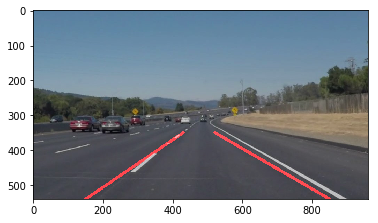

In [5]:
find_lane_lines("test_images/solidWhiteCurve.jpg")

-0.5319220151828848
0.5929275068662596
Image saved: True


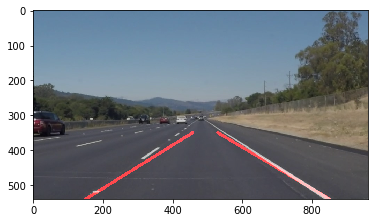

In [6]:
find_lane_lines("test_images/solidWhiteRight.jpg")

-0.6268913004207122
0.5552308802308802
Image saved: True


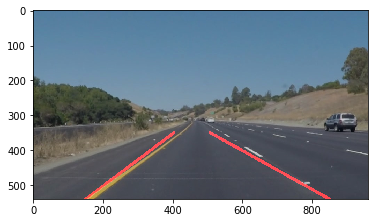

In [7]:
find_lane_lines('test_images/solidYellowCurve.jpg')

-0.5333228905597326
0.5938123644836625
Image saved: True


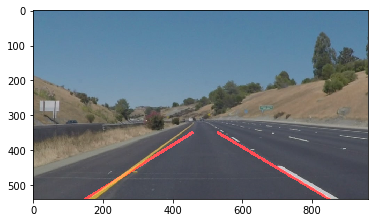

In [8]:
find_lane_lines('test_images/solidYellowCurve2.jpg')

-0.6663193511065667
0.6622552051123479
Image saved: True


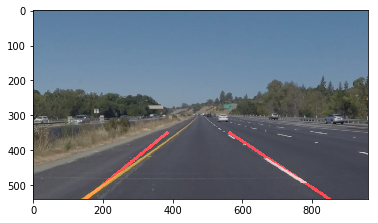

In [9]:
find_lane_lines('test_images/solidYellowLeft.jpg')

-0.6605412301064475
0.6104290418229037
Image saved: True


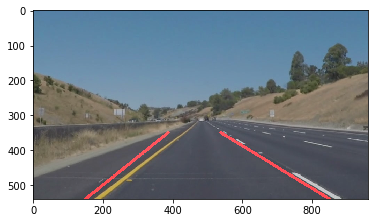

In [10]:
find_lane_lines('test_images/whiteCarLaneSwitch.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ModuleNotFoundError: No module named 'moviepy'

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    result = find_lane_lines(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

NameError: name 'VideoFileClip' is not defined

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))